# Applied Data Science Capstone


This notebook will be mainly used for the capstone project.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


# Data

## 1) The neighborhood data

 We scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.

In [2]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

In [3]:
# Now we will read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))
neigh = soup.find('table')
table_str = str(neigh.extract())

In [4]:
df_neigh = pd.read_html(table_str)[0]
df_neigh.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
df_neigh = df_neigh.drop(df_neigh[df_neigh.Borough == 'Not assigned'].index)

In [6]:
df_neigh.rename(columns = {"Postcode": "PostalCode", "Neighbourhood": "Neighborhood"}, inplace = True)

In [9]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
df_neigh['Neighborhood'].replace('Not assigned', df_neigh['Borough'], inplace=True)

In [10]:
#More than one neighborhood can exist in one postal code area.
df_neigh['Neighborhood'] = (df_neigh['Neighborhood'].replace('\/',',', regex=True)
                        .replace(' ,',',', regex=True) 
                        .astype(str))

In [11]:
df_neigh.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_neigh['Borough'].unique()),
        df_neigh.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


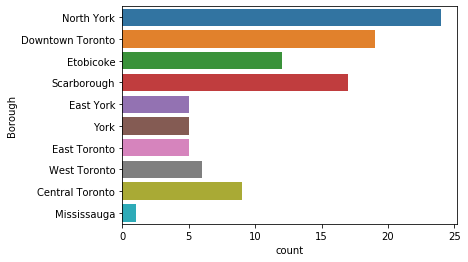

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.countplot(y='Borough', data=df_neigh)
plt.savefig('data3.png', bbox_inches='tight')

In [ ]:
#df_grouped = df_neigh.groupby(['Borough','Postal Code'], as_index=False).agg(lambda x:','.join(x))
#df_grouped.head()

## 2) The latitude and the longitude coordinates of each neighborhood.

The geographical coordinates of each postal code:

In [14]:
file_name ='https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(file_name)
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now we merge  Geocoder and neighborhood dataframe:

In [28]:
df = pd.merge(df_neigh, df_geo, on='Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [29]:
df.drop(['Postal Code'], axis=1, inplace=True)
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Use geopy library to get the latitude and longitude values of Toronto.

In [21]:
address = 'Toronto'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of  Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of  Toronto are 43.6534817, -79.3839347.


In [22]:
#Create list with the Boroughs (to be used later)
boroughs = df['Borough'].unique().tolist()
boroughs

['North York',
 'Downtown Toronto',
 'Etobicoke',
 'Scarborough',
 'East York',
 'York',
 'East Toronto',
 'West Toronto',
 'Central Toronto',
 'Mississauga']

In [23]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

Create a map of Toronto with neighborhoods superimposed on top.

In [24]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=borough_color[borough],
        fill=True,
        fill_color=borough_color[borough],
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## 3) Define Foursquare Credentials and Version

To get a list of all the Venues in Toronto which included Parks, Schools, Café Shops, Asian Restaurants etc. Getting this data was crucial to analyzing the number of vegetrian Restaurants all over Toronto. 

In [30]:
CLIENT_ID = '1TWWHYOVWCGVA3FVLBNQEMRNGH2YTRWSBZCXJ4IHWQLRXK2X' # your Foursquare ID
CLIENT_SECRET = 'UHK5JCQJM4KH23EEPBCBSLKGIGQPVTQBHMZUUHPQ0FXKD2FS' # your Foursquare Secret
VERSION = '20201202' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1TWWHYOVWCGVA3FVLBNQEMRNGH2YTRWSBZCXJ4IHWQLRXK2X
CLIENT_SECRET:UHK5JCQJM4KH23EEPBCBSLKGIGQPVTQBHMZUUHPQ0FXKD2FS


### Explore Neighborhoods in North York

for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in North York. So let's slice the original dataframe and create a new dataframe of the North York data.

In [31]:
df_NorthYork= df[df['Borough'] == 'North York'].reset_index(drop=True)
df_NorthYork.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
3,North York,Don Mills,43.745906,-79.352188
4,North York,Glencairn,43.709577,-79.445073


In [33]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
# type your answer here
NorthYork_venues = getNearbyVenues(names=df_NorthYork['Neighborhood'],
                                   latitudes=df_NorthYork['Latitude'],
                                   longitudes=df_NorthYork['Longitude']
                                  )

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview
York Mills, Silver Hills
Downsview
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale, Willowdale East
Downsview
York Mills West
Willowdale, Willowdale West


In [35]:
NorthYork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [36]:
#Venues per Neighborhood
NorthYork_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",22,22,22,22,22,22
Don Mills,23,23,23,23,23,23
Downsview,16,16,16,16,16,16
"Fairview, Henry Farm, Oriole",70,70,70,70,70,70
Glencairn,5,5,5,5,5,5
Hillcrest Village,5,5,5,5,5,5
Humber Summit,2,2,2,2,2,2


In [37]:
print('There are {} distinct venues in {} categories.'.format(
    len(NorthYork_venues['Venue'].unique()),len(NorthYork_venues['Venue Category'].unique())))

There are 205 distinct venues in 103 categories.


In [38]:
print(NorthYork_venues.shape)

(241, 7)


# 4) Cluster the neighborhoods in Toronto

In [39]:
# one hot encoding
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]

NorthYork_onehot.head()

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Electronics Store,Event Space,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Liquor Store,Locksmith,Lounge,Luggage Store,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [40]:
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_grouped

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,Bar,Baseball Field,Beer Store,Bike Shop,Boutique,Bridal Shop,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Electronics Store,Event Space,Fast Food Restaurant,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gas Station,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hockey Arena,Home Service,Hotel,Ice Cream Shop,Indian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Juice Bar,Liquor Store,Locksmith,Lounge,Luggage Store,Martial Arts School,Massage Studio,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Movie Theater,Park,Pet Store,Pharmacy,Pizza Place,Plaza,Pool,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Spa,Sporting Goods Shop,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Video Game Store,Vietnamese Restaurant,Women's Store
0,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.047619,0.047619,0.000000,0.047619,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.0,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Bayview Village,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.250000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bedford Park, Lawrence Manor East",0.000000,0.0000,0.045455,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000,0.090909,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.045455,0.045455,0.000000,0.0000,0.000000,0.0000,0.000000,0.000000,0.045455,0.000000,0.090909,0.000000,0.045455,0.045455,0.045455,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Each neighborhood with the top 5 venues

In [41]:
num_top_venues = 10

for hood in NorthYork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bathurst Manor, Wilson Heights, Downsview North----
                       venue  freq
0                Coffee Shop  0.10
1                       Bank  0.10
2                Pizza Place  0.05
3         Frozen Yogurt Shop  0.05
4              Deli / Bodega  0.05
5                   Pharmacy  0.05
6  Middle Eastern Restaurant  0.05
7         Chinese Restaurant  0.05
8                 Restaurant  0.05
9             Sandwich Place  0.05


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1                 Café  0.25
2                 Bank  0.25
3  Japanese Restaurant  0.25
4    Accessories Store  0.00
5        Luggage Store  0.00
6                 Park  0.00
7        Movie Theater  0.00
8    Mobile Phone Shop  0.00
9   Miscellaneous Shop  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.09
1  Italian Restaurant  0.09
2         Coffee Shop  0.09
3    Greek Restaurant  0.05
4       Grocery Store  0.05
5 

##### Let's put that into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']

for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Shopping Mall,Chinese Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Deli / Bodega,Pharmacy,Pizza Place,Ice Cream Shop
1,Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,Electronics Store,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop


## Cluster Neighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [44]:
# set number of clusters
kclusters = 5

NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(NorthYork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 4, 4, 4, 4, 4, 4, 4, 3, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans.labels_)

NorthYork_merged = df_NorthYork

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NorthYork_merged.head(5) # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,ClusterLabels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,0.0,Park,Food & Drink Shop,Discount Store,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store
1,North York,Victoria Village,43.725882,-79.315572,4.0,Coffee Shop,French Restaurant,Pizza Place,Hockey Arena,Portuguese Restaurant,Intersection,Diner,Comfort Food Restaurant,Construction & Landscaping,Convenience Store
2,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,4.0,Clothing Store,Women's Store,Vietnamese Restaurant,Boutique,Coffee Shop,Event Space,Furniture / Home Store,Gift Shop,Accessories Store,Supermarket
3,North York,Don Mills,43.745906,-79.352188,4.0,Gym,Beer Store,Coffee Shop,Japanese Restaurant,Caribbean Restaurant,Clothing Store,Chinese Restaurant,Café,Dim Sum Restaurant,Italian Restaurant
4,North York,Glencairn,43.709577,-79.445073,4.0,Park,Bakery,Pizza Place,Pub,Japanese Restaurant,Food Truck,Dessert Shop,Coffee Shop,Comfort Food Restaurant,Construction & Landscaping


In [46]:
NorthYork_merged = NorthYork_merged.dropna()   
#NorthYork_merged = NorthYork_merged.drop(NorthYork_merged[NorthYork_merged.ClusterLabels == 'NaN'].index)

In [ ]:
#NorthYork_merged.ClusterLabels.dtype
#NorthYork_merged.astype({'ClusterLabels': 'int64'}).dtypes

In [47]:
>>> NorthYork_merged['ClusterLabels'] = NorthYork_merged['ClusterLabels'].apply(np.int64)

Finally, let's visualize the resulting clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NorthYork_merged['Latitude'], NorthYork_merged['Longitude'], NorthYork_merged['Neighborhood'], NorthYork_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters